In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Mounted at /content/drive


In [32]:
%cd /content/drive/MyDrive/RL Portfolio Optimization

/content/drive/MyDrive/RL Portfolio Optimization


In [3]:
#Installing Minimal Dependencies
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn

In [31]:
# notebooks/1_regime_detection.ipynb
import pandas as pd
import numpy as np

df = pd.read_csv("data/ohlcv_data.csv", header=[0, 1], index_col=0, parse_dates=True)
spy = df['SPY'].copy().reset_index()  # reset_index() Moves Date from index to a column
spy.index.name = None

# Feature Engineering
# pct_change() calculates % change between the current adjusted Close price and the previous one in a time series.
spy['returns'] = spy['Close'].pct_change()
# Calculate 20-day rolling volatility (standard deviation of returns)
spy['volatility'] = spy['returns'].rolling(window=20).std()
#Calculate 20-day momentum (price change over 20 days)
spy['momentum'] = spy['Close'].pct_change(periods=20)

# clean the data - remove rows with missing values due to rolling window.
spy = spy.dropna().reset_index(drop=True)
spy.head()


Price,Date,Open,High,Low,Close,Volume,returns,volatility,momentum
0,2015-02-02,167.074826,168.728450,165.245812,168.636581,163107000,0.012384,0.011050,-0.017086
1,2015-02-03,169.538570,171.083631,169.162749,171.075272,124212900,0.014461,0.010767,0.015467
2,2015-02-04,170.306921,171.526268,169.964500,170.423843,134306700,-0.003808,0.010557,0.021219
3,2015-02-05,171.091968,172.294608,171.016806,172.144272,97953200,0.010095,0.010435,0.018832
4,2015-02-06,172.511771,173.079690,171.142100,171.668259,125672000,-0.002765,0.009682,-0.001700


In [34]:
import sys
sys.path.append('/content/RL Portfolio Optimization/src')  # Adjust path if needed

from src.regime_detector import detect_regimes

spy = detect_regimes(spy)

spy.head()

Price,Date,Open,High,Low,Close,Volume,returns,volatility,momentum,regime
0,2015-03-31,173.869074,174.573754,173.114075,173.172791,126768700,-0.008739,0.009188,-0.017850,0
1,2015-04-01,173.139202,173.164368,171.562079,172.560364,137303600,-0.003537,0.009176,-0.017180,0
2,2015-04-02,172.493223,173.634119,172.308666,173.181122,86900900,0.003597,0.009220,-0.014723,0
3,2015-04-06,172.283485,174.867278,172.149272,174.347168,114368200,0.006733,0.008797,0.006061,0
4,2015-04-07,174.372348,175.127346,173.852238,173.885788,81236300,-0.002646,0.008773,-0.000743,0


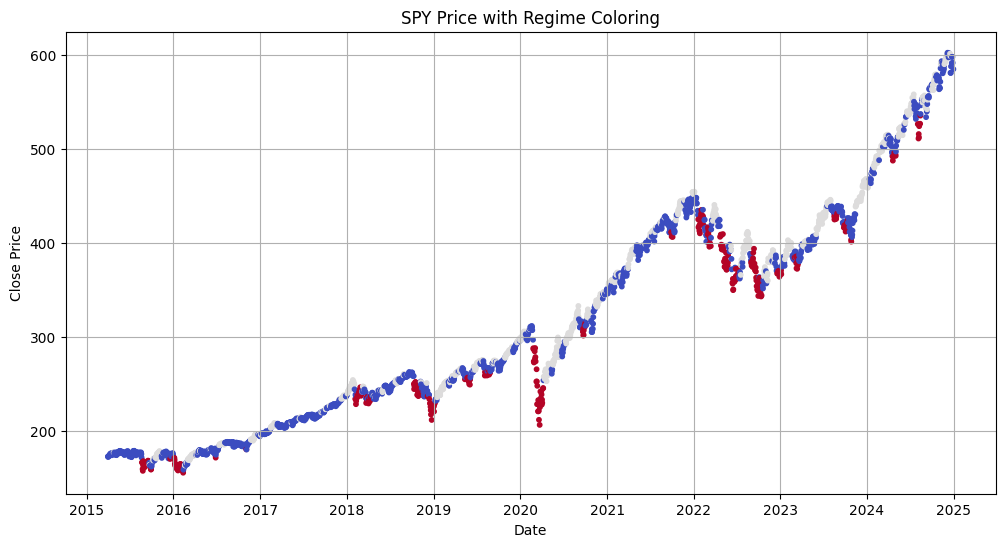

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.title("SPY Price with Regime Coloring")
plt.scatter(spy['Date'], spy['Close'], c=spy['regime'], cmap='coolwarm', s=10)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [37]:
'''
Notes: Since KMeans clustering is unsupervised, it assigns each day to a regime (0, 1, or 2) without telling us what that regime means.
Running this line lets you reverse-engineer what each cluster represents, by looking at the average volatility and momentum values for each regime group.
'''
spy.groupby('regime')[['volatility', 'momentum']].mean()

#output interpretation [0: Volatile.Neutral, 1:Bull, 2:Bear]

Price,volatility,momentum
regime,,
0,0.007890,0.005277
1,0.008597,0.049097
2,0.016262,-0.065498


In [39]:
# Save the regime-labeled SPY dataset
output_path = "data/spy_regime_labeled.csv"
spy.to_csv(output_path, index=False)

print(f"Saved regime-labeled dataset to {output_path}")


Saved regime-labeled dataset to data/spy_regime_labeled.csv
